[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb)

# Extending the Linear Representation Hypothesis with Sparse and Transcoder-Style Autoencoders for Hallucination Analysis

This notebook demonstrates an extension of the LRH using Sparse Autoencoders (SAEs) and Transcoder-Style Autoencoders by steering features in GPT-2 associated with hallucinations to demonstrate such steering can influence model outputs. The benchmark dataset used is the LAMBADA dataset, which contains cloze-style (i.e. 'fill-in-the-blank) problems. This notebook takes inspiration from the
[TransformerLens](https://github.com/TransformerLensOrg/TransformerLens/) library's [Exploratory Analysis demo Colab Notebook](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb).

## Setup

### Environment Setup

**Note**: Be sure to switch runtime to use a GPU for faster compute (e.g. T4 GPU).  If you have access to a high-RAM GPU (i.e. if you have Colab Pro), switching to use it will enable much better performance and allow for larger calculations (e.g. using the full dataset as opposed to a small subset for certain operations).

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
HIGH_RAM = True

if ram_gb < 20:
  HIGH_RAM = False
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
!pip install transformer_lens
!pip install circuitsvis
!pip install sae-lens
!pip install pandas
!pip uninstall -y numpy
!pip install numpy==1.26.4 # Newer numpy versions have dependency conflicts with pandas
# Install a faster Node version
!curl -fsSL https://deb.nodesource.com/setup_21.x | sudo -E bash -; sudo apt-get install -y nodejs  # noqa

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
2025-05-02 03:06:25 - Installing pre-requisites
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://deb.nodesource.com/node_21.x nodistro InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.c

### Imports

**Important Note**: Sometimes numpy fails to use the specified version (v1.26.4) after being imported, which causes an error when importing the rest of the libraries due to dependency conflicts.  If the following doesn't print '1.26.4', then restart session via: 'Runtime' --> 'Restart Session' to fix the issue.

In [ ]:
import numpy as np
print(np.__version__) # Should be 1.26.4
assert np.__version__ == '1.26.4'

1.26.4


The above block should have printed '1.26.4'.  If not, then restart session via 'Runtime' --> 'Restart Session'.  Else, continue.



In [ ]:
import torch
import scipy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datasets import load_dataset
import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer
from sae_lens import SAE

### PyTorch Setup

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [ ]:
torch.set_grad_enabled(False)
print("Disabled automatic differentiation")

Disabled automatic differentiation


### Model and Dataset Import

In [ ]:
# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained("gpt2-small")
model.eval()

# Get the default device used
device: torch.device = utils.get_device()
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (h

In [ ]:
lambada = load_dataset("lambada", split="test")

# Inspect a sample problem
example_prompt, example_answer = lambada[0]['text'].rsplit(' ', 1)
print('Question: ' + example_prompt + '\n')
print('Answer: ' + example_answer)

Generating train split:   0%|          | 0/2662 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5153 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4869 [00:00<?, ? examples/s]

Question: in my palm is a clear stone , and inside it is a small ivory statuette . a guardian angel . `` figured if you 're going to be out at night getting hit by cars , you might as well have some backup . '' i look at him , feeling stunned . like this is some sort of sign . but as i stare at harlin , his mouth curved in a confident grin , i do n't care about

Answer: signs


We verify that our model can 'do' a task from this (LAMBADA) dataset (note that not all tasks may pass; we just want to verify that the model can do at least one of the tasks):

In [ ]:
example_prompt, example_answer = lambada[8]['text'].rsplit(' ', 1)
utils.test_prompt(example_prompt, example_answer, model, print_details=True, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '``', ' why', ' ?', " ''", ' ``', ' i', ' would', ' have', ' thought', ' you', " '", 'd', ' find', ' him', ' rather', ' dry', ' ,', " ''", ' she', ' said', ' .', ' ``', ' i', ' do', ' n', "'t", ' know', ' about', ' that', ' ,', " ''", ' said', ' g', 'ab', 'riel', ' .', ' ``', ' he', ' was', ' a', ' great', ' crafts', 'man', ' ,', " ''", ' said', ' he', 'ather', ' .', ' ``', ' that', ' he', ' was', ' ,', " ''", ' said', ' fl', 'an', 'nery', ' .', ' ``', ' and', ' polish', ' ,', ' to', ' boot', ' ,', " ''", ' said']
Tokenized answer: [' g', 'ab', 'riel']


Performance on answer token:
Rank: 0        Logit: 12.41 Prob:  6.08% Token: | g|

Top 0th token. Logit: 12.41 Prob:  6.08% Token: | g|
Top 1th token. Logit: 12.26 Prob:  5.24% Token: | he|
Top 2th token. Logit: 11.55 Prob:  2.57% Token: | j|
Top 3th token. Logit: 11.44 Prob:  2.31% Token: | m|
Top 4th token. Logit: 11.37 Prob:  2.16% Token: | l|
Top 5th token. Logit: 11.22 Prob:  1.86% Token: | the|
Top 6th token. Logit: 11.17 Prob:  1.77% Token: | she|
Top 7th token. Logit: 11.07 Prob:  1.60% Token: | b|
Top 8th token. Logit: 11.04 Prob:  1.55% Token: | d|
Top 9th token. Logit: 11.00 Prob:  1.50% Token: | t|


Performance on answer token:
Rank: 0        Logit: 20.36 Prob: 89.14% Token: |ab|

Top 0th token. Logit: 20.36 Prob: 89.14% Token: |ab|
Top 1th token. Logit: 15.36 Prob:  0.60% Token: |abby|
Top 2th token. Logit: 14.62 Prob:  0.29% Token: |az|
Top 3th token. Logit: 14.30 Prob:  0.21% Token: |ordon|
Top 4th token. Logit: 14.19 Prob:  0.19% Token: |ib|
Top 5th token. Logit: 14.15 Prob:  0.18% Token: |im|
Top 6th token. Logit: 14.10 Prob:  0.17% Token: |har|
Top 7th token. Logit: 14.00 Prob:  0.15% Token: |abe|
Top 8th token. Logit: 13.89 Prob:  0.14% Token: |abb|
Top 9th token. Logit: 13.86 Prob:  0.13% Token: |ag|


Performance on answer token:
Rank: 0        Logit: 21.65 Prob: 99.19% Token: |riel|

Top 0th token. Logit: 21.65 Prob: 99.19% Token: |riel|
Top 1th token. Logit: 14.42 Prob:  0.07% Token: |ri|
Top 2th token. Logit: 14.08 Prob:  0.05% Token: |ry|
Top 3th token. Logit: 13.78 Prob:  0.04% Token: |rie|
Top 4th token. Logit: 13.73 Prob:  0.04% Token: |rin|
Top 5th token. Logit: 13.61 Prob:  0.03% Token: |rier|
Top 6th token. Logit: 13.60 Prob:  0.03% Token: |rian|
Top 7th token. Logit: 13.31 Prob:  0.02% Token: |ric|
Top 8th token. Logit: 13.03 Prob:  0.02% Token: |rius|
Top 9th token. Logit: 12.98 Prob:  0.02% Token: |ril|


Ranks of the answer tokens: [(' g', 0), ('ab', 0), ('riel', 0)]

## Model Accuracy Calculation

Here, we take in the model's output token rankings and consider an answer correct iff token_rank=0 for all output/answer tokens.  As the LAMBADA dataset has one-word (though potentially multi-token) answers, we don't consider partial credit.

In [ ]:
# Note: Code from function test_prompt() in the
# [TransformerLens Library](https://github.com/TransformerLensOrg/TransformerLens/blob/main/transformer_lens/utils.py)
def get_out_tokens(prompt, answer, model):

  answers = [answer] if isinstance(answer, str) else answer
  n_answers = len(answers)
  using_multiple_answers = n_answers > 1

  answers = [answer if answer.startswith(" ") else " " + answer for answer in answers]

  # GPT-2 often treats the first token weirdly, so lets give it a resting position
  prompt_tokens = model.to_tokens(prompt, prepend_bos=True)
  answer_tokens = model.to_tokens(answers, prepend_bos=False)

  # If we have multiple answers, we're only allowed a single token generation
  if using_multiple_answers:
    answer_tokens = answer_tokens[:, :1]

  # Deal with case where answers is a list of strings
  prompt_tokens = prompt_tokens.repeat(answer_tokens.shape[0], 1)
  tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)

  prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=True)
  answer_str_tokens_list = [model.to_str_tokens(answer, prepend_bos=False) for answer in answers]

  prompt_length = len(prompt_str_tokens)
  answer_length = 1 if using_multiple_answers else len(answer_str_tokens_list[0])

  logits = model(tokens)
  probs = logits.softmax(dim=-1)
  answer_ranks = []

  for index in range(prompt_length, prompt_length + answer_length):
    # Get answer tokens for this sequence position
    answer_tokens = tokens[:, index]
    answer_str_tokens = [a[index - prompt_length] for a in answer_str_tokens_list]

    # Offset by 1 because models predict the NEXT token
    token_probs = probs[:, index - 1]
    sorted_token_probs, sorted_token_positions = token_probs.sort(descending=True)
    answer_token_ranks = sorted_token_positions.argsort(-1)[
      range(n_answers), answer_tokens.cpu()
    ].tolist()
    answer_ranks.append(
      [
        (answer_str_token, answer_token_rank)
          for answer_str_token, answer_token_rank in zip(
            answer_str_tokens, answer_token_ranks
          )
      ]
    )

  # If n_answers = 1 then unwrap answer ranks, so printed output matches original version of function
  if not using_multiple_answers:
    single_answer_ranks = [r[0] for r in answer_ranks]
    return single_answer_ranks
  else:
    return answer_ranks


def is_correct(out_tokens):
  for pair in out_tokens:
    if pair[1] != 0:
      return False, pair[1]
  return True, pair[1]


def is_prediction_correct(prompt, answer, model):
  out_tokens = get_out_tokens(prompt, answer, model)
  return is_correct(out_tokens)


def calc_accuracy(data, model):
  correct = 0
  hallucinating_prompts = []
  for entry in tqdm(data, 'Calculating Accuracy'):
    prompt, answer = entry['text'].rsplit(' ', 1)

    pred_corr, token_rank = is_prediction_correct(prompt, answer, model)
    if pred_corr:
      correct += 1
    else:
      hallucinating_prompts.append((prompt, token_rank))
  return correct / len(data), hallucinating_prompts

In [ ]:
gpt2_accuracy, hallucinations = calc_accuracy(lambada, model)
print('\n' + 'Accuracy: ' + str(gpt2_accuracy))

Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Sort the hallucinating prompts in order of worst performing prediction
hallucinations.sort(key=lambda x: -1 * x[1])
hallucinating_prompts = [prompt for prompt, _ in hallucinations]

We now have GPT-2's accuracy on the LAMBADA dataset as well as the prompts on which it hallucinated!

## SAEs

### Interpreting with SAEs

In [ ]:
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

# hook_point = "blocks.8.hook_resid_post"
hook_point = "blocks.8.hook_attn_out"

# Load SAE and model
sae, cfg_dict, sparsity = SAE.from_pretrained(
  # release="gpt2-small-resid-post-v5-32k",
  release="gpt2-small-attn-out-v5-32k",
  sae_id=hook_point,
  device=device
)
sae.hook_point = hook_point

sae.to(device)

NameError: name 'torch' is not defined

We now hook the SAE into the model and run on the prompts that caused the original GPT-2 model to fail/hallucinate/predict incorrectly. This will yield the top features that correspond to hallucinations in this (LAMBADA) dataset, i.e. for cloze-style/fill-in-the-blank-style prompts.

In [ ]:
import gc

all_sae_features = []

#  def sae_hook(activations, hook):
#    sae_features = sae.encode(activations)
#    return sae.decode(sae_features)
#
#  model.add_hook(hook_point, sae_hook)

subset_frac = 0.05

# Use a subset of worst ~05% performing prompts
batch_size = 4
num_prompts_to_analyse = int(subset_frac * len(hallucinating_prompts)) // batch_size * batch_size

print(f"Analysing {num_prompts_to_analyse} prompts...")

top_hallucinating_prompts = hallucinating_prompts[:num_prompts_to_analyse]

# Run model and get activations
with torch.no_grad():
  max_seq_len = 0
  for i in tqdm(range(0, num_prompts_to_analyse, batch_size), 'Retrieving Activations'):
    batch_prompts = top_hallucinating_prompts[i : i + batch_size]

    _, cache = model.run_with_cache(batch_prompts)
    x_mid = cache[hook_point]  # [batch, seq, d_model]

    sae_features = sae.encode(x_mid)  # [batch, seq, d_sae]
    max_seq_len = max(max_seq_len, sae_features.shape[1])

    if HIGH_RAM:
      all_sae_features.append(sae_features.cpu())
    else:
      all_sae_features.append(sae_features)

    # Prevent OutOfMemoryError
    del cache
    del x_mid
    del sae_features
    torch.cuda.empty_cache()
    gc.collect()

Analysing 188 prompts...


Retrieving Activations:   0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
# Pad tensors to the maximum sequence length before concatenation
sae_features_list = []
for sae_feature_batch in tqdm(all_sae_features, 'Padding Tensors'):
  padding_shape = (0, 0, 0, max_seq_len - sae_feature_batch.shape[1])
  padded_batch = torch.nn.functional.pad(sae_feature_batch, padding_shape)
  sae_features_list.append(padded_batch)

  del sae_feature_batch
  del padding_shape
  del padded_batch
  torch.cuda.empty_cache()
  gc.collect()

if HIGH_RAM:
  sae_features = torch.cat(sae_features_list, dim=0).to(device)
else:
  sae_features = torch.cat(sae_features_list, dim=0)

del sae_features_list
del all_sae_features
torch.cuda.empty_cache()
gc.collect()

Padding Tensors:   0%|          | 0/47 [00:00<?, ?it/s]

18

In [ ]:
def rank_features(activations, top_k=10):
  """
  Correctly ranks SAE features across batches and sequence positions
  """
  # Compute metrics across batch and sequence dimensions
  chunk_size = 100
  num_features = activations.shape[-1]
  mean_acts = torch.zeros(num_features, device=activations.device)
  firing_rates = torch.zeros(num_features, device=activations.device)

  for i in range(0, activations.shape[0], chunk_size):
    chunk = activations[i:i + chunk_size]
    mean_acts += chunk.mean(dim=(0, 1)) * chunk.shape[0]  # Weighted average
    firing_rates += (chunk > 0).float().mean(dim=(0, 1)) * chunk.shape[0]  # Weighted average

  mean_acts /= activations.shape[0]  # Normalize
  firing_rates /= activations.shape[0]  # Normalize

  # Combined score
  scores = 0.7*mean_acts + 0.3*firing_rates # [num_features]

  # Get top indices
  return torch.topk(scores, k=top_k).indices.cpu().numpy()  # [top_k]

In [ ]:
top_k = 20
top_feature_indices = rank_features(sae_features, top_k)
print('Top Features:', top_feature_indices)

Top Features: [15071  8217 13271 11694 14659  1254  6884  5182  5990 22491  8324 14472
 12296 23097 17384 14947 31223 30395  6216 16665]


We now check the cosine similarity of these top features.  Assuming the LRH holds, they should all be roughly aligned (i.e. cosine similarities of > 0.7):

In [ ]:
vec_top = sae.W_dec[top_feature_indices[:top_k]].sum(dim=0)

print(f"Top {top_k} norm:", vec_top.norm().item())

top_W_dec = sae.W_dec[top_feature_indices[:top_k]]  # [top_k, d_model]

for i in range(top_k):
    for j in range(i+1, top_k):
        cos_sim = torch.nn.functional.cosine_similarity(top_W_dec[i], top_W_dec[j], dim=0)
        print(f"Cosine(W_dec[{i}], W_dec[{j}]) = {cos_sim.item():.3f}")

Top 20 norm: 5.186397552490234
Cosine(W_dec[0], W_dec[1]) = 0.063
Cosine(W_dec[0], W_dec[2]) = 0.195
Cosine(W_dec[0], W_dec[3]) = 0.031
Cosine(W_dec[0], W_dec[4]) = -0.001
Cosine(W_dec[0], W_dec[5]) = 0.061
Cosine(W_dec[0], W_dec[6]) = 0.041
Cosine(W_dec[0], W_dec[7]) = 0.096
Cosine(W_dec[0], W_dec[8]) = -0.026
Cosine(W_dec[0], W_dec[9]) = 0.176
Cosine(W_dec[0], W_dec[10]) = 0.058
Cosine(W_dec[0], W_dec[11]) = -0.081
Cosine(W_dec[0], W_dec[12]) = 0.039
Cosine(W_dec[0], W_dec[13]) = 0.041
Cosine(W_dec[0], W_dec[14]) = 0.057
Cosine(W_dec[0], W_dec[15]) = -0.207
Cosine(W_dec[0], W_dec[16]) = 0.023
Cosine(W_dec[0], W_dec[17]) = -0.026
Cosine(W_dec[0], W_dec[18]) = 0.015
Cosine(W_dec[0], W_dec[19]) = 0.137
Cosine(W_dec[1], W_dec[2]) = 0.054
Cosine(W_dec[1], W_dec[3]) = 0.021
Cosine(W_dec[1], W_dec[4]) = 0.007
Cosine(W_dec[1], W_dec[5]) = 0.015
Cosine(W_dec[1], W_dec[6]) = 0.044
Cosine(W_dec[1], W_dec[7]) = 0.041
Cosine(W_dec[1], W_dec[8]) = -0.020
Cosine(W_dec[1], W_dec[9]) = 0.019
Cosine(W

In [ ]:
aligned_features = [
  [f for f in top_feature_indices[:top_k]
    if torch.nn.functional.cosine_similarity(sae.W_dec[f], sae.W_dec[feat_idx], dim=0) > 0.5
  ]
  for feat_idx in top_feature_indices[:top_k]
]

print(aligned_features)

[[15071], [8217], [13271], [11694], [14659], [1254], [6884], [5182], [5990], [22491], [8324], [14472], [12296], [23097], [17384], [14947], [31223], [30395], [6216], [16665]]


These results show the opposite! Rather than being aligned, almost all features are orthogonal to, or at least not codirectional with, each other! This suggests that hallucination-inducing features actually lie in a multi-dimensional space!

In [ ]:
from transformers import AutoTokenizer

def process_lambada(top_features, dataset, model, sae, feature_k=0, max_examples=5):
    """Analyze and visualize top features across LAMBADA examples"""
    device = model.cfg.device
    tokenizer = model.tokenizer

    # Analyze each example
    for idx in range(min(len(dataset), max_examples)):
        text = dataset[idx]['text']
        prompt = ' '.join(text.split()[:-1])
        answer = text.split()[-1]

        # Tokenize and process
        tokens = tokenizer.encode(prompt, return_tensors="pt").to(device)
        with torch.no_grad():
            _, cache = model.run_with_cache(tokens)
            hidden = cache[sae.hook_point]
            sae_activations = sae.encode(hidden)[0]  # [seq_len, d_sae]

        # Get token strings with special characters handled
        token_strs = tokenizer.batch_decode(tokens[0], clean_up_tokenization_spaces=False)

        # Visualize top features for this example
        print(f"\nExample {idx+1}: ")

        feat_idx = top_features[feature_k]  # Show top k features

        feature_acts = sae_activations[:, feat_idx]

        # Highlight activation in context
        colored_tokens = []
        for i, (token, act) in enumerate(zip(token_strs, feature_acts)):
            intensity = min(int(act.item() * 10), 255)
            color_code = f"\033[38;2;{intensity};0;0m"
            reset_code = "\033[0m"
            colored_tokens.append(f"{color_code}[{token}]{reset_code}")


        print(f"Feature {feat_idx} (max act: {feature_acts.max():.2f}):")
        print(f"  - Prompt: '{prompt}'")
        print(f"  - Answer: '{answer}'")
        print(" ".join(colored_tokens) + "\n")

# Usage
process_lambada(
    top_features=top_feature_indices,
    dataset=lambada,
    model=model,
    sae=sae,
    feature_k=0,
    max_examples=20
)



Example 1: 
Feature 15071 (max act: 16.85):
  - Prompt: 'in my palm is a clear stone , and inside it is a small ivory statuette . a guardian angel . `` figured if you 're going to be out at night getting hit by cars , you might as well have some backup . '' i look at him , feeling stunned . like this is some sort of sign . but as i stare at harlin , his mouth curved in a confident grin , i do n't care about'
  - Answer: 'signs'
[in] [ my] [ palm] [ is] [ a] [ clear] [ stone] [ ,] [ and] [ inside] [ it] [ is] [ a] [ small] [ ivory] [ stat] [u] [ette] [ .] [ a] [ guardian] [ angel] [ .] [ ``] [ figured] [ if] [ you] [ '] [re] [ going] [ to] [ be] [ out] [ at] [ night] [ getting] [ hit] [ by] [ cars] [ ,] [ you] [ might] [ as] [ well] [ have] [ some] [ backup] [ .] [ ''] [ i] [ look] [ at] [ him] [ ,] [ feeling] [ stunned] [ .] [ like] [ this] [ is] [ some] [ sort] [ of] [ sign] [ .] [ but] [ as] [ i] [ stare] [ at] [ har] [lin] [ ,] [ his] [ mouth] [ curved] [ in] [ a] [ confident] [ gr

### Feature Steering

In [ ]:
def setup_pca_steering_multi(feature_indices, factor):
  with torch.no_grad():
    vec = sae.W_dec[feature_indices] # [top_k, d_model]

  def pca_steering_hook(activations, hook):
    if factor == 0.0:
      return activations
    # Run PCA
    vec_local = vec.to(activations.device)
    U, S, Vh = torch.pca_lowrank(vec_local)
    principal_vec = Vh[:, 0] * S[0]  # dominant hallucination direction

    steered = activations.clone()
    steered[:, -2, :] += principal_vec * factor # steer only final token
    return steered

  return pca_steering_hook

In [ ]:
def setup_steering(feature_idx, factor):
    """Steer multiple SAE features with scaled vector"""

    with torch.no_grad():
        steering_vec = sae.W_dec[feature_idx].clone()  # [d_model]

    def steering_hook(activations, hook):
        if factor == 0.0:
            return activations
        steering_vec_local = steering_vec.to(activations.device)
        steered = activations.clone()
        steered[:, -2, :] += steering_vec_local * factor  # steer only final token
        return steered

    return steering_hook

In [ ]:
mag_factor = 20
hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in top_feature_indices[:top_k]]

with model.hooks(hooks):
  hooked_accuracy, hallucinations = calc_accuracy(lambada, model)
  print('\n' + 'Accuracy: ' + str(hooked_accuracy))

Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]


Accuracy: 0.117795458955948


## Transcoders

### Training Transcoder

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
torch.set_grad_enabled(True)
print("Enabled automatic differentiation")

Enabled automatic differentiation


In [ ]:
d_sae = sae.W_dec.shape[0]
d_trans = 1
subset_frac = 0.05

In [ ]:
# Define Transcoder Module
class Transcoder(nn.Module):
  def __init__(self, d_sae, d_trans):
    super().__init__()
    self.T = nn.Linear(d_sae, d_trans, bias=False)  # T maps sparse SAE space to hallucination space

  def forward(self, sae_activations):
    return self.T(sae_activations)

In [ ]:
def extract_sae_feats_from_hallucinations(model, sae, hallucinations, hook_point):
  sae_feats_list = []
  labels = []

  for prompt, token_rank in tqdm(hallucinations, desc="Extracting SAE features"):
    tokens = model.to_tokens(prompt, prepend_bos=True)

    with torch.no_grad():
      _, cache = model.run_with_cache(tokens)
      resid = cache[hook_point]             # [1, seq, d_model]
      sae_act = sae.encode(resid)[0, -2, :] # [d_sae]

    sae_feats_list.append(sae_act.cpu())
    labels.append([token_rank])  # higher rank = more hallucinated

  sae_feats = torch.stack(sae_feats_list)  # [N, d_sae]
  hallucination_scores = torch.tensor(labels, dtype=torch.float32)  # [N, 1]

  return sae_feats, hallucination_scores

In [ ]:
sae_feats, halluc_scores = extract_sae_feats_from_hallucinations(
  model=model,
  sae=sae,
  hallucinations=hallucinations[:int(subset_frac * len(hallucinations))],
  hook_point=hook_point
)

Extracting SAE features:   0%|          | 0/227 [00:00<?, ?it/s]

In [ ]:
# Min-max normalise to avoid exploding gradients
halluc_scores = (halluc_scores - halluc_scores.min()) / (halluc_scores.max() - halluc_scores.min())

In [ ]:
def create_dataloader(sae_feats, halluc_scores, batch_size=64):
    dataset = TensorDataset(sae_feats, halluc_scores)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataloader = create_dataloader(sae_feats, halluc_scores)

In [ ]:
def train_transcoder(T, dataloader, n_epochs=10, lr=1e-3, l1_lambda=1e-4):
  opt = torch.optim.Adam(T.parameters(), lr=lr)

  for epoch in range(n_epochs):
    total_loss = 0
    for x, y in dataloader:
      opt.zero_grad()
      out = T(x)  # [B, d_trans]
      loss = F.mse_loss(out, y)

      # Encourage sparsity
      l1 = l1_lambda * T.T.weight.abs().sum()
      loss += l1

      loss.backward()
      opt.step()
      total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")
  return T

In [ ]:
from sklearn.model_selection import train_test_split

train_feats, val_feats, train_labels, val_labels = train_test_split(
    sae_feats, halluc_scores, test_size=0.2
)

T = Transcoder(d_sae=d_sae, d_trans=d_trans)
loader = create_dataloader(train_feats, train_labels)

T = train_transcoder(T, loader, n_epochs=50)

Epoch 1 | Loss: 0.0762
Epoch 2 | Loss: 0.0515
Epoch 3 | Loss: 0.0402
Epoch 4 | Loss: 0.0280
Epoch 5 | Loss: 0.0193
Epoch 6 | Loss: 0.0153
Epoch 7 | Loss: 0.0118
Epoch 8 | Loss: 0.0090
Epoch 9 | Loss: 0.0071
Epoch 10 | Loss: 0.0060
Epoch 11 | Loss: 0.0054
Epoch 12 | Loss: 0.0051
Epoch 13 | Loss: 0.0047
Epoch 14 | Loss: 0.0045
Epoch 15 | Loss: 0.0042
Epoch 16 | Loss: 0.0039
Epoch 17 | Loss: 0.0038
Epoch 18 | Loss: 0.0036
Epoch 19 | Loss: 0.0036
Epoch 20 | Loss: 0.0034
Epoch 21 | Loss: 0.0034
Epoch 22 | Loss: 0.0033
Epoch 23 | Loss: 0.0032
Epoch 24 | Loss: 0.0032
Epoch 25 | Loss: 0.0030
Epoch 26 | Loss: 0.0031
Epoch 27 | Loss: 0.0030
Epoch 28 | Loss: 0.0029
Epoch 29 | Loss: 0.0029
Epoch 30 | Loss: 0.0029
Epoch 31 | Loss: 0.0029
Epoch 32 | Loss: 0.0029
Epoch 33 | Loss: 0.0028
Epoch 34 | Loss: 0.0028
Epoch 35 | Loss: 0.0028
Epoch 36 | Loss: 0.0027
Epoch 37 | Loss: 0.0028
Epoch 38 | Loss: 0.0028
Epoch 39 | Loss: 0.0027
Epoch 40 | Loss: 0.0027
Epoch 41 | Loss: 0.0026
Epoch 42 | Loss: 0.0027
E

In [ ]:
with torch.no_grad():
    val_preds = T(val_feats)
    val_loss = F.mse_loss(val_preds, val_labels)
    print(f"Validation MSE: {val_loss.item():.4f}")

Validation MSE: 0.0117


### Interpreting with Transcoders

In [ ]:
torch.save(T.state_dict(), "transcoder_halluc.pth")
T_loaded = Transcoder(d_sae=T.T.in_features, d_trans=1)
T_loaded.load_state_dict(torch.load("transcoder_halluc.pth"))
T_loaded.eval()

Transcoder(
  (T): Linear(in_features=32768, out_features=1, bias=False)
)

In [ ]:
halluc_w = T_loaded.T.weight[0]
top_idx = torch.topk(halluc_w.abs(), k=top_k).indices
for f in top_idx:
    print(f"Feature {f:>5}  weight = {halluc_w[f]:+.4f}")

Feature 27584  weight = +0.0256
Feature  2776  weight = +0.0253
Feature 25459  weight = +0.0253
Feature 11661  weight = -0.0252
Feature 12375  weight = +0.0237
Feature 31255  weight = +0.0236
Feature  9911  weight = +0.0221
Feature 15782  weight = +0.0215
Feature  2908  weight = -0.0213
Feature 31828  weight = -0.0210
Feature 32454  weight = +0.0207
Feature 11623  weight = +0.0205
Feature 32191  weight = +0.0205
Feature 30594  weight = -0.0198
Feature 27139  weight = -0.0197
Feature  7387  weight = +0.0196
Feature  6719  weight = +0.0196
Feature  2134  weight = +0.0195
Feature 22299  weight = -0.0192
Feature 16004  weight = +0.0189


In [ ]:
sorted_indices = torch.argsort(halluc_w.abs(), descending=True)
for f in top_feature_indices:
  rank = (sorted_indices == f).nonzero(as_tuple=True)[0].item()
  print(f"Feature {f} has rank {rank}/{d_sae} in absolute weight magnitude.")

Feature 15071 has rank 345/32768 in absolute weight magnitude.
Feature 8217 has rank 365/32768 in absolute weight magnitude.
Feature 13271 has rank 323/32768 in absolute weight magnitude.
Feature 11694 has rank 751/32768 in absolute weight magnitude.
Feature 14659 has rank 15939/32768 in absolute weight magnitude.
Feature 1254 has rank 288/32768 in absolute weight magnitude.
Feature 6884 has rank 127/32768 in absolute weight magnitude.
Feature 5182 has rank 31363/32768 in absolute weight magnitude.
Feature 5990 has rank 469/32768 in absolute weight magnitude.
Feature 22491 has rank 154/32768 in absolute weight magnitude.
Feature 8324 has rank 664/32768 in absolute weight magnitude.
Feature 14472 has rank 24333/32768 in absolute weight magnitude.
Feature 12296 has rank 32701/32768 in absolute weight magnitude.
Feature 23097 has rank 13553/32768 in absolute weight magnitude.
Feature 17384 has rank 316/32768 in absolute weight magnitude.
Feature 14947 has rank 29041/32768 in absolute weig

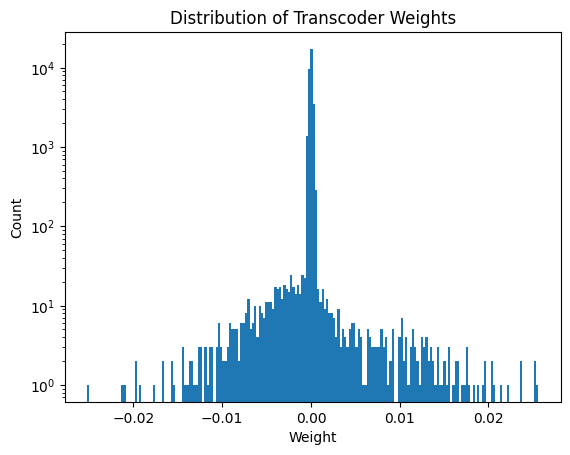

In [ ]:
plt.hist(halluc_w.detach().cpu(), bins=200, log=True)
plt.title("Distribution of Transcoder Weights")
plt.xlabel("Weight"); plt.ylabel("Count"); plt.show()

In [ ]:
steer_vec = sae.W_dec.T @ halluc_w.to(sae.W_dec.device)
print("Residual-space norm:", steer_vec.norm().item())

Residual-space norm: 0.25179019570350647


### Feature Steering

In [ ]:
def setup_transcoder_steering(sae, T, factor):
  def steering_hook(activations, hook):
    if factor == 0.0:
      return activations

    device = activations.device
    halluc_dir_sae = T.T.weight[0].to(device)  # shape: [d_sae]
    steer_features = halluc_dir_sae * mag_factor  # shape: [d_sae]
    steer_vector = sae.W_dec.T @ steer_features  # shape: [d_model]

    # Inject into final token (or more, if desired)
    steered = activations.clone()
    steered[:, -2, :] += steer_vector
    return steered
  return steering_hook

In [ ]:
mag_factor = 20
hook = [(sae.hook_point, setup_transcoder_steering(sae, T, mag_factor))]

with model.hooks(hook):
    acc, _ = calc_accuracy(lambada, model)
    print(f"Accuracy after steering: {acc:.3f}")

Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy after steering: 0.268


## Results

In [ ]:
mag_factors = [-5.0, -2.0, 0.0, 5.0, 10.0, 15.0]
k_vals = [5, 10, 20]

We also collect accuracy values for steering a random selection of 10 features for use as a baseline/control comparison when plotting steering accuracy vs magnification factor for the top SAE-selected features across different numbers of features selected.

**Note**: This block of code is computationally intensive and takes ~25 minutes to run.

In [ ]:
import random
random.seed(100)

control_results = []
k = 10
random_features = random.sample(range(sae.W_dec.shape[0]), k)

print(f'Calculating for {k} Randomly Selected Features...')
for mag_factor in mag_factors:
  print(f'Mag Factor: {mag_factor}x')
  random_hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in random_features]
  with model.hooks(random_hooks):
    accuracy, _ = calc_accuracy(lambada, model)
    print(f'Accuracy: {accuracy}')
    control_results.append(accuracy)

Calculating for 10 Randomly Selected Features...
Mag Factor: -5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.27168639627401514
Mag Factor: -2.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2712982728507665
Mag Factor: 0.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2699398408693965
Mag Factor: 5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.26431205123229184
Mag Factor: 10.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2549970890743256
Mag Factor: 15.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.23947215214438192


**Note**: The next block of code is *very* computationally intensive and will take ~60 minutes to run.

In [ ]:
# Plot model accuracy on LAMBADA vs magnification factors of top {5, 10, 15, 20} hallucination-inducing features
results = []

for k_val in k_vals:
  accuracy_results = []
  print(f'Calculating for Top {k_val} Features...')
  for mag_factor in mag_factors:
    print(f'Mag Factor: {mag_factor}x')
    hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in top_feature_indices[:k_val]]
    with model.hooks(hooks):
      accuracy, _ = calc_accuracy(lambada, model)
      accuracy_results.append(accuracy)
      print(f'Accuracy: {accuracy}')
  results.append(accuracy_results)

Calculating for Top 5 Features...
Mag Factor: -5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2666407917717834
Mag Factor: -2.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2687754705996507
Mag Factor: 0.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2699398408693965
Mag Factor: 5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.27168639627401514
Mag Factor: 10.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.274209198525131
Mag Factor: 15.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2736270133902581
Calculating for Top 10 Features...
Mag Factor: -5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.267028915195032
Mag Factor: -2.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2687754705996507
Mag Factor: 0.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2699398408693965
Mag Factor: 5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.26896953231127496
Mag Factor: 10.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.26431205123229184
Mag Factor: 15.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.25654958276732
Calculating for Top 20 Features...
Mag Factor: -5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.26896953231127496
Mag Factor: -2.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.27149233456239086
Mag Factor: 0.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2699398408693965
Mag Factor: 5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2536386570929556
Mag Factor: 10.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.22064816611682514
Mag Factor: 15.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.16980399767125945


In [ ]:
# Compute the Confidence Interval for the accuracy metric of the steered model
def normal_ci(accuracies, n, ci=95):
  accuracies = np.array(accuracies)
  z = 1.96 if ci == 95 else scipy.stats.norm.ppf(1 - (1 - ci / 100) / 2)
  se = np.sqrt(accuracies * (1 - accuracies) / n)
  return accuracies - z * se, accuracies + z * se

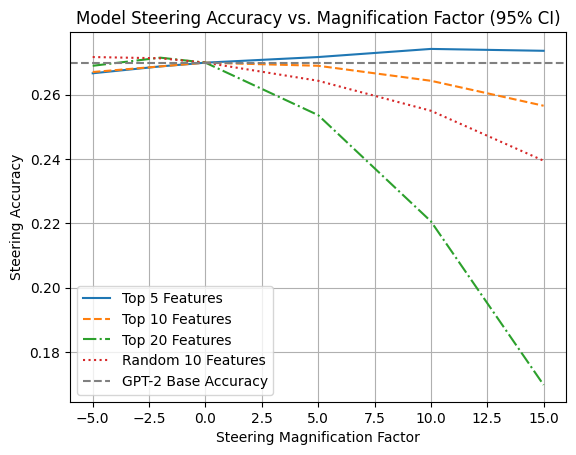

In [ ]:
# Plot Accuracy vs Steering Coefficient with 95% Confidence Bars
linestyles = ['-', '--', '-.']
for i in range(len(results)):
  l, u = normal_ci(results[i], num_prompts_to_analyse)
  err = np.array([np.array(results[i]) - l, u - np.array(results[i])])
  #plt.errorbar(mag_factors,
  #             results[i],
  #             yerr=err,
  #             label=f'Top {k_vals[i]} Features',
  #             capsize=5,
  #             capthick=2,
  #             elinewidth=1.5)

  # plt.fill_between(mag_factors, l, u, alpha=0.2)
  plt.plot(mag_factors, results[i], linestyle=linestyles[i], label=f'Top {k_vals[i]} Features')

l, u = normal_ci(control_results, num_prompts_to_analyse)
control_err = np.array([np.array(control_results) - l, u - np.array(control_results)])
#plt.errorbar(mag_factors,
#             control_results,
#             yerr=control_err,
#             label=f'Random {k} Features',
#             capsize=5,
#             capthick=2,
#             elinewidth=1.5)

# plt.fill_between(mag_factors, l, u, alpha=0.2)
plt.plot(mag_factors, control_results, linestyle=':', label=f'Random {k} Features')

plt.axhline(y=gpt2_accuracy, color='gray', linestyle='--', label='GPT-2 Base Accuracy')
plt.xlabel('Steering Coefficient')
plt.ylabel('Steering Accuracy')
plt.title('Model Steering Accuracy vs. Steering Coefficient (95% CI)')
plt.grid(True)
plt.legend()
plt.show()

We now compare the effect of steering the top feature vs a random feature

In [ ]:
single_control_results = []
random_features = random.sample(range(sae.W_dec.shape[0]), 1)

print(f'Calculating for {1} Randomly Selected Feature...')
for mag_factor in mag_factors:
  print(f'Mag Factor: {mag_factor}x')
  random_hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in random_features]
  with model.hooks(random_hooks):
    accuracy, _ = calc_accuracy(lambada, model)
    print(f'Accuracy: {accuracy}')
    single_control_results.append(accuracy)

Calculating for 1 Randomly Selected Feature...
Mag Factor: -5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2678051620415292
Mag Factor: -2.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2687754705996507
Mag Factor: 0.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2699398408693965
Mag Factor: 5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.27052202600426933
Mag Factor: 10.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2685814088880264
Mag Factor: 15.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.26547642150203765


In [ ]:
# Plot model accuracy on LAMBADA vs Steering Coefficients of top hallucination-inducing feature
single_results = []

print(f'Calculating for Top {1} Features...')
for mag_factor in mag_factors:
  print(f'Mag Factor: {mag_factor}x')
  hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in top_feature_indices[:1]]
  with model.hooks(hooks):
    accuracy, _ = calc_accuracy(lambada, model)
    print(f'Accuracy: {accuracy}')
    single_results.append(accuracy)

Calculating for Top 20 Features...
Mag Factor: -5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2685814088880264
Mag Factor: -2.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.26896953231127496
Mag Factor: 0.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2699398408693965
Mag Factor: 5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.27110421113914224
Mag Factor: 10.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.27091014942751795
Mag Factor: 15.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.27071608771589367


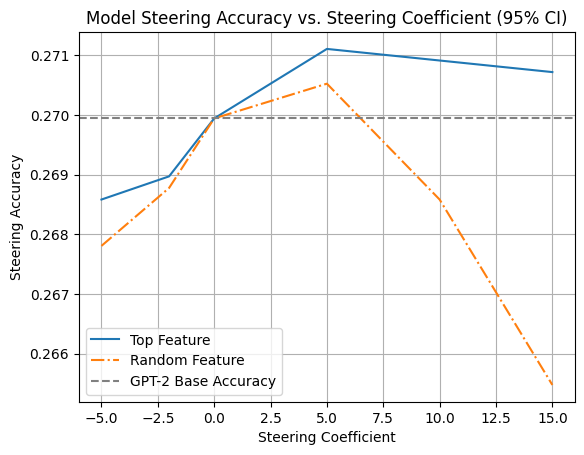

In [ ]:
# Plot Accuracy vs Steering Coefficients with 95% Confidence Bars

l, u = normal_ci(single_results, num_prompts_to_analyse)
err = np.array([np.array(single_results) - l, u - np.array(single_results)])
#plt.errorbar(mag_factors,
#             results[i],
#             yerr=err,
#             label=f'Top {k_vals[i]} Features',
#             capsize=5,
#             capthick=2,
#             elinewidth=1.5)

# plt.fill_between(mag_factors, l, u, alpha=0.2)
plt.plot(mag_factors, single_results, linestyle='-', label=f'Top Feature')


l, u = normal_ci(single_control_results, num_prompts_to_analyse)
control_err = np.array([np.array(single_control_results) - l, u - np.array(single_control_results)])
#plt.errorbar(mag_factors,
#             control_results,
#             yerr=control_err,
#             label=f'Random {k} Features',
#             capsize=5,
#             capthick=2,
#             elinewidth=1.5)

# plt.fill_between(mag_factors, l, u, alpha=0.2)
plt.plot(mag_factors, single_control_results, linestyle='-.', label=f'Random Feature')

plt.axhline(y=gpt2_accuracy, color='gray', linestyle='--', label='GPT-2 Base Accuracy')
plt.xlabel('Steering Coefficient')
plt.ylabel('Steering Accuracy')
plt.title('Model Steering Accuracy vs. Steering Coefficient (95% CI)')
plt.grid(True)
plt.legend()
plt.show()